<a href="https://colab.research.google.com/github/bitnurihan/Machine-Learning/blob/master/tensorflow_grp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing
from sklearn.model_selection import KFold
import numpy as np
print(tf.__version__)

1.15.0


In [0]:
def build_grp_model(train):
  model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=[len(train.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  # optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
  return model

In [0]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')

  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')

  plt.legend()
  plt.show()


In [0]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

In [0]:
df = pd.read_csv('MLraw_data_group_period_separate.csv')
df['target'] = df['target'].astype('category')
df['channel'] = df['channel'].astype('category')
# df['month'] = df['month'].astype('category')
df['cost'] = df['cost']*1000
df['cost_log'] = np.log(df['cost']+1)
df = df.drop(columns='reach_per')
# df = df.drop(columns='cost')

X = pd.get_dummies(df, prefix_sep='_')
train, test = train_test_split(X, test_size=0.2)

train_labels = train.pop('grp')
test_labels = test.pop('grp')

cost_labels = train.pop('cost')
cost_test_labels = test.pop('cost')
train.columns
# sns.kdeplot(df['cost_log'])


Index(['month', 'cost_log', 'channel_CJE&M', 'channel_KBSN', 'channel_MBCPLUS',
       'channel_SBS미디어넷', 'channel_etc', 'channel_종합편성채널', 'channel_지상파3개채널',
       'target_769', 'target_1019', 'target_2029', 'target_3039',
       'target_4049', 'target_5059', 'target_6069'],
      dtype='object')

In [0]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(train)
X_test_scaled = scaler.transform(test)
X_train_scaled

array([[ 0.        , -0.85423981,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.        ,  0.27747347,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.        ,  0.05436769,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.77281775,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  1.8718658 ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.28049462,  0.        , ...,  1.        ,
         0.        ,  0.        ]])

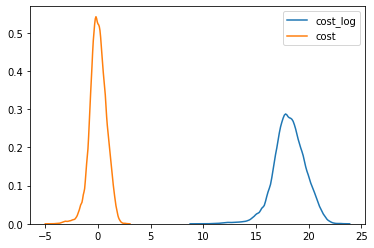

In [0]:
grp_train = pd.DataFrame(X_train_scaled, columns=['month', 'cost', 'channel_CJE&M', 'channel_KBSN', 'channel_MBCPLUS',
       'channel_SBS미디어넷', 'channel_etc', 'channel_종합편성채널', 'channel_지상파3개채널',
       'target_769', 'target_1019', 'target_2029', 'target_3039',
       'target_4049', 'target_5059', 'target_6069'])

grp_test = pd.DataFrame(X_test_scaled, columns=['month', 'cost', 'channel_CJE&M', 'channel_KBSN', 'channel_MBCPLUS',
       'channel_SBS미디어넷', 'channel_etc', 'channel_종합편성채널', 'channel_지상파3개채널',
       'target_769', 'target_1019', 'target_2029', 'target_3039',
       'target_4049', 'target_5059', 'target_6069'])
sns.kdeplot(df['cost_log'])
sns.kdeplot(grp_train['cost'])


In [0]:
grp_model = build_grp_model(grp_train)
grp_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_16 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 65        
Total params: 10,497
Trainable params: 10,497
Non-trainable params: 0
_________________________________________________________________


In [0]:
example_batch = grp_train[:10]
example_result = grp_model.predict(example_batch)
example_result

array([[ 0.05741927],
       [ 0.23147726],
       [-0.22191057],
       [ 0.04602899],
       [ 0.4602313 ],
       [ 0.12880881],
       [ 0.11259504],
       [ 0.08905183],
       [ 0.00981657],
       [ 0.1914328 ]], dtype=float32)


.............................

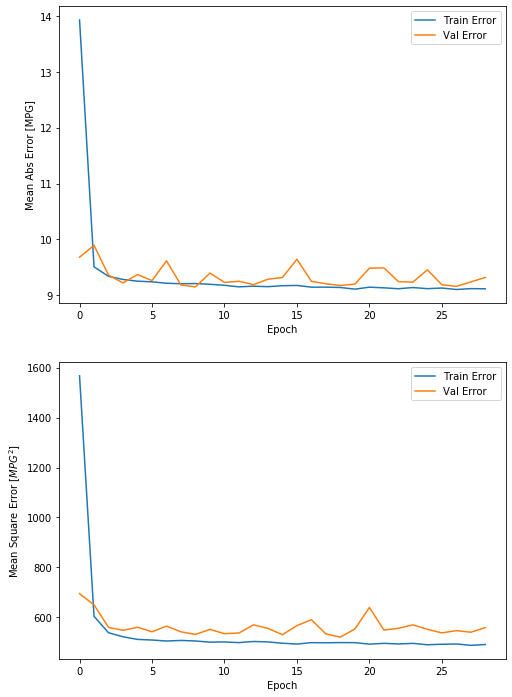

In [0]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS = 300
history = grp_model.fit(grp_train, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)
grp_model.save('grp_model.h5')

In [0]:
loss, mae, mse = grp_model.evaluate(grp_test, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

64601/64601 - 2s - loss: 488.0301 - mean_absolute_error: 9.1906 - mean_squared_error: 488.0304
테스트 세트의 평균 절대 오차:  9.19 MPG


Text(0, 0.5, 'Predictions [MPG]')

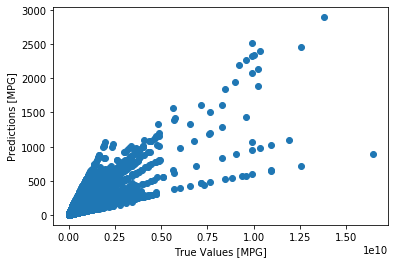

In [0]:
test_grp_predictions = grp_model.predict(grp_test).flatten()

plt.scatter(cost_test_labels, test_grp_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')

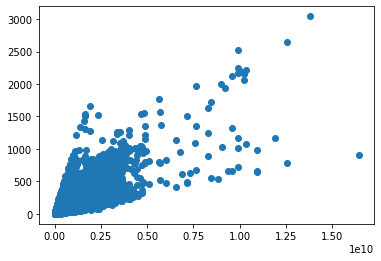

In [0]:
plt.scatter(cost_test_labels, test_labels)

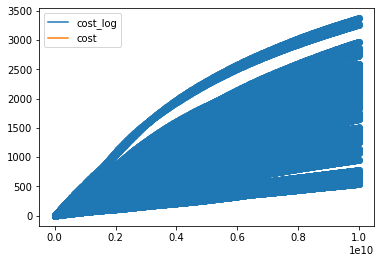

In [0]:
grp_test2 = pd.read_csv('grp_test.csv')
grp_test2 = grp_test2.drop(columns='Unnamed: 0')
grp_test2['target'] = grp_test2['target'].astype('category')
grp_test2['channel'] = grp_test2['channel'].astype('category')
grp_test2['cost'] = grp_test2['cost']*1000
grp_test2['cost_log'] = np.log(grp_test2['cost']+1)
grp_test2['cost_log']
grp = pd.get_dummies(grp_test2, prefix_sep='_')
cost_label = grp.pop('cost')
grp
X_test_scaled = scaler.transform(grp)
X_test_scaled

grp_testing = pd.DataFrame(X_test_scaled, columns=['month', 'cost', 'channel_CJE&M', 'channel_KBSN', 'channel_MBCPLUS',
       'channel_SBS미디어넷', 'channel_etc', 'channel_종합편성채널', 'channel_지상파3개채널',
       'target_769', 'target_1019', 'target_2029', 'target_3039',
       'target_4049', 'target_5059', 'target_6069'])
grp_testing
sns.kdeplot(grp_test2['cost_log'])
sns.kdeplot(grp_testing['cost'])
test_grp_predictions = grp_model.predict(grp_testing).flatten()
test_grp_predictions
grp_predict = pd.DataFrame(test_grp_predictions)
reach_test = pd.concat([grp_test2, grp_predict], axis=1)
reach_test = reach_test.rename(columns={0:'grp'})
reach_test
reach_test.to_csv('reach_test.csv')
plt.scatter(cost_label, test_grp_predictions)
